# Quality Classification

Import the Required libraries

In [32]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [33]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [37]:
#Read the data
df = pd.read_csv('winequality-red.csv')
#drop the quality column - response variable
df_temp = df.drop('quality', axis=1)
#Normalize data
df_norm = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())

#quality greater than 6 is considered good, assign 1 and quality less than or equal to 6 is considered not good so assign 0
q = df['quality'].apply(lambda x: 1 if x > 6 else 0)

#concat q and df_norm
df_norm = pd.concat((df_norm, q), 1)
print(df_norm)
df=df_norm.copy()

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.247788          0.397260         0.00        0.068493   0.106845   
1          0.283186          0.520548         0.00        0.116438   0.143573   
2          0.283186          0.438356         0.04        0.095890   0.133556   
3          0.584071          0.109589         0.56        0.068493   0.105175   
4          0.247788          0.397260         0.00        0.068493   0.106845   
...             ...               ...          ...             ...        ...   
1594       0.141593          0.328767         0.08        0.075342   0.130217   
1595       0.115044          0.294521         0.10        0.089041   0.083472   
1596       0.150442          0.267123         0.13        0.095890   0.106845   
1597       0.115044          0.359589         0.12        0.075342   0.105175   
1598       0.123894          0.130137         0.47        0.184932   0.091820   

      free sulfur dioxide  

In [38]:
df.iloc[0]

fixed acidity           0.247788
volatile acidity        0.397260
citric acid             0.000000
residual sugar          0.068493
chlorides               0.106845
free sulfur dioxide     0.140845
total sulfur dioxide    0.098940
density                 0.567548
pH                      0.606299
sulphates               0.137725
alcohol                 0.153846
quality                 0.000000
Name: 0, dtype: float64

# Create formula for design matrices

In [39]:
formula = 'quality ~ ' + ' + '.join(['Q("'+x+'")' \
                                    for x in df.columns.values\
                                    if x != 'quality'])
print(formula)

quality ~ Q("fixed acidity") + Q("volatile acidity") + Q("citric acid") + Q("residual sugar") + Q("chlorides") + Q("free sulfur dioxide") + Q("total sulfur dioxide") + Q("density") + Q("pH") + Q("sulphates") + Q("alcohol")


In [40]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['quality'].values

# Create training and testing sets

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

# Classifiers

In [42]:
# All the models we want to test out
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=10,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=200,
                               max_depth=4,
                               random_state=1)

# Model Fitting

In [43]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


# Accuracy Score

In [44]:
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test})
df

,Training Accuracy,Test Accuracy
Decision Tree,1.000000,0.870833
Bagging,0.991957,0.922917
Random Forest,0.990170,0.914583
Gradient Boosting,1.000000,0.906250


Text(0, 0.5, 'Test accuracy')

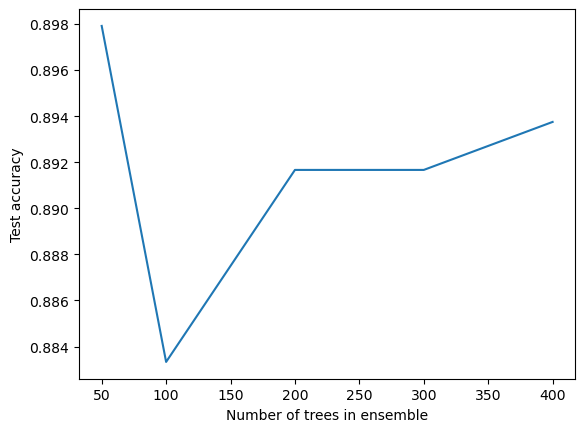

In [25]:
scores = {}
for num_trees in [50, 100, 200, 300, 400]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=2,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Number of trees in ensemble')
ylabel('Test accuracy')

In [ ]:
#300 trees is enough

Text(0, 0.5, 'Test accuracy')

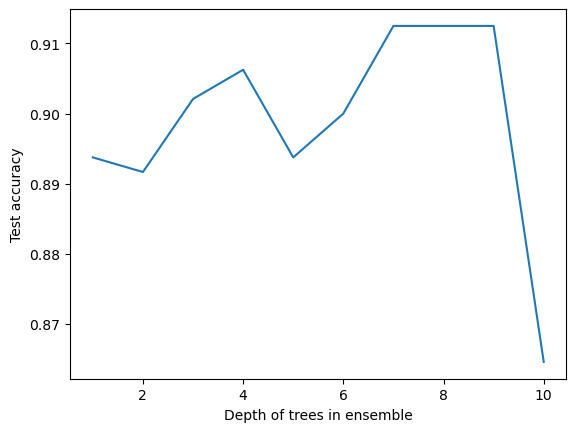

In [27]:
scores = {}
for depth in range(1, 11):
    model = GradientBoostingClassifier(n_estimators=200,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Depth of trees in ensemble')
ylabel('Test accuracy')

In [ ]:
#above graph 7 seems to be better

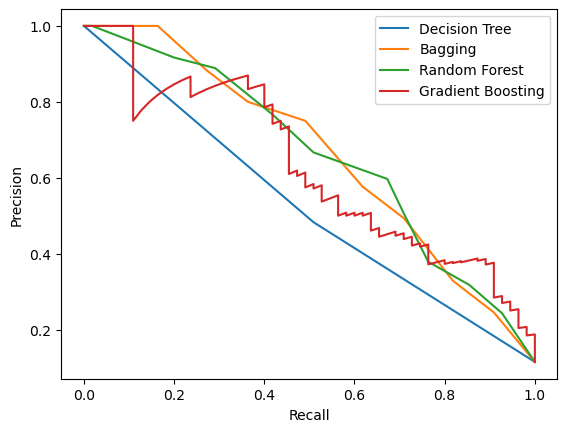

In [29]:
from sklearn.metrics import precision_recall_curve

for index, (name, model) in enumerate(models.items()):
    predictions = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, predictions[:, 1])
    plot(recall, precision, label=name)

xlabel('Recall')
ylabel('Precision')
legend(loc='best')
savefig('download')